# Paintings by Style: CLIP + UMAP Scatter

This notebook mirrors the Picasso embedding plot, but uses `data/paintings-by-style.csv`. Points are colored by `style`, and hover shows artist, title, and year.

In [1]:
# NOTE: Style dataset loader: reads data/paintings-by-style.csv (Abstract Expressionism, Analytical Cubism, Impressionism, Surrealism) and normalizes columns for the style experiments.
# Artist name is parsed into df['artist'] from rel_path (style/artist/filename) so later cells can group/hover by artist.
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.preprocessing import MinMaxScaler
import umap
import plotly.express as px
from plotly.colors import qualitative as pq
from IPython.display import display
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **k: x

_HERE = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
_ROOT = _HERE.parent
RESULTS_DIR = _ROOT / 'result-artifacts'
DATA_DIR = _ROOT / 'data' / 'paintings-by-style'
CSV_PATH = _ROOT / 'data' / 'paintings-by-style.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

df = pd.read_csv(CSV_PATH)
# Normalize column names for easier access
df = df.rename(columns={
    'directory+filename': 'rel_path',
    'painting title': 'title',
    'year of painting': 'year'
})
# Derive artist from rel_path: style/artist/filename
def extract_artist(p: str) -> str:
    parts = str(p).split('/')
    return parts[1] if len(parts) >= 2 else ''

df['artist'] = df['rel_path'].astype(str).map(extract_artist)
df['image_path'] = df['rel_path'].apply(lambda p: str(DATA_DIR / p))
df['year'] = pd.to_numeric(df['year'], errors='coerce')
print(f'Loaded {len(df)} rows from {CSV_PATH.name}')
display(df.head())

Loaded 140 rows from paintings-by-style.csv


,rel_path,title,year,style,artist,image_path
0,abstract-expressionism/kline/1950-chief.jpg,chief,1950,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
1,abstract-expressionism/kline/1954-number-2.jpg,number 2,1954,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
2,abstract-expressionism/kline/1955-white-forms.jpg,white forms,1955,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
3,abstract-expressionism/kline/1961-le-gros.jpg,le gros,1961,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
4,abstract-expressionism/kline/1961-meryon.jpg,meryon,1961,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...


In [2]:
# CLIP image embeddings are computed once per row and stored in `embeddings` / `emb_matrix`, aligned with df order for downstream metrics.
# Compute CLIP embeddings
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return clip_processor(images=image, return_tensors='pt')['pixel_values']

embeddings = []
failed = []
for p in tqdm(df['image_path'], desc='Extracting CLIP embeddings'):
    try:
        pixel_values = preprocess_image(p).to(DEVICE)
        with torch.no_grad():
            emb = clip_model.get_image_features(pixel_values=pixel_values)
        embeddings.append(emb.squeeze().cpu().numpy())
    except Exception as e:
        failed.append((p, str(e)))
        embeddings.append(np.zeros(512, dtype=np.float32))

if failed:
    print(f'Failed to embed {len(failed)} images (filled with zeros).')

emb_matrix = np.vstack(embeddings)
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(emb_matrix)
df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting CLIP embeddings: 100%|██████████| 140/140 [00:09<00:00, 14.43it/s]
/Users/roryashton/coding-repositories/ml-art-representation/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [3]:
# Interactive scatter colored by style with informative hover
# Enforce equal axis range for a square canvas
xmin, xmax = df['x'].min(), df['x'].max()
ymin, ymax = df['y'].min(), df['y'].max()
xc, yc = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
half = max(xmax - xmin, ymax - ymin) / 2.0
half = 0.5 if half <= 0 else half

# Use a vivid, categorical color map per style
_style_cats = pd.Categorical(df['style']).categories.tolist()
_palette = (pq.Dark24 + pq.Vivid + pq.Bold)
_color_map = {cat: _palette[i % len(_palette)] for i, cat in enumerate(_style_cats)}

fig = px.scatter(
    df, x='x', y='y', color='style', color_discrete_map=_color_map,
    hover_name='title',
    hover_data={'artist': True, 'year': True, 'style': False, 'rel_path': False},
    width=900, height=900,
)
fig.update_layout(
    title='CLIP Embedding of Paintings by Style (UMAP Projection)',
    template='plotly_white',
)
fig.update_xaxes(range=[xc - half, xc + half], visible=True, constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1, visible=True, constrain='domain')

# Enforce equal aspect and square grid cells by using identical ranges and tick steps
import math
def nice_dtick(range_span: float, target_ticks: int = 8) -> float:
    raw = max(range_span / max(target_ticks, 1), 1e-9)
    mag = 10 ** math.floor(math.log10(raw))
    norm = raw / mag
    if norm <= 1: base = 1
    elif norm <= 2: base = 2
    elif norm <= 5: base = 5
    else: base = 10
    return base * mag

rng = 2 * half
dt = nice_dtick(rng, target_ticks=8)

fig.update_layout(
    width=900,
    height=900,
    template='plotly_white',
    legend=dict(
        title='Style',
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=1.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1,
    ),
    margin=dict(t=80, r=220, b=60, l=60),
)
fig.update_xaxes(range=[xc - half, xc + half], tickmode='linear', dtick=dt, constrain='domain')
fig.update_yaxes(range=[yc - half, yc + half], tickmode='linear', dtick=dt, scaleanchor='x', scaleratio=1, constrain='domain')
fig.show()

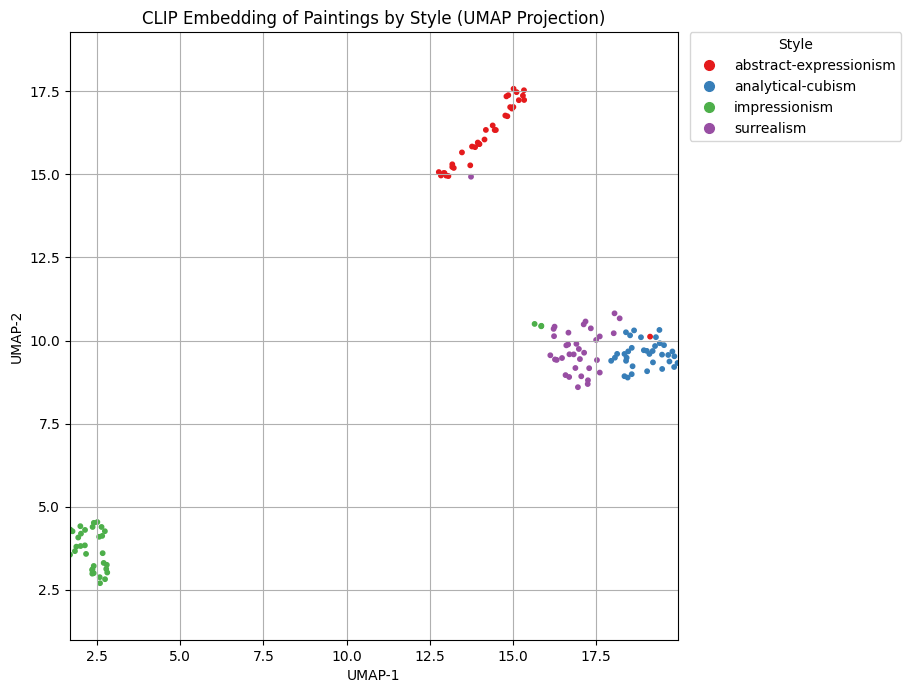

In [4]:
# Matplotlib reference with guaranteed square grid cells (mirrors Picasso notebook)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 9))
# Map styles to distinct colors
styles = pd.Categorical(df['style'])
# High-contrast categorical palette (ColorBrewer Set1)
base = sns.color_palette('Set1', n_colors=8)
palette = [base[i % len(base)] for i in range(len(styles.categories))]
color_map = dict(zip(styles.categories, palette))
colors = df['style'].map(color_map)
scatter = ax.scatter(df['x'], df['y'], c=colors, s=10)
legend_handles = [
    Line2D(
        [0], [0],
        marker='o', linestyle='None', markersize=7,
        markerfacecolor=color_map[style], markeredgecolor=color_map[style],
        label=style,
    )
    for style in styles.categories
]
ax.legend(
    handles=legend_handles,
    title='Style',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.0,
    frameon=True,
)
fig.subplots_adjust(right=0.8)
ax.grid(True)

xmin, xmax = df['x'].min(), df['x'].max()
ymin, ymax = df['y'].min(), df['y'].max()
xc, yc = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
half = max(xmax - xmin, ymax - ymin) / 2.0
half = 0.5 if half <= 0 else half
ax.set_xlim(xc - half, xc + half)
ax.set_ylim(yc - half, yc + half)
ax.set_aspect('equal', adjustable='box')
try:
    ax.set_box_aspect(1)
except Exception:
    pass
ax.set_title('CLIP Embedding of Paintings by Style (UMAP Projection)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.show()


In [5]:
# Silhouette score for style clusters in CLIP space
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Full CLIP embedding space
X_full = np.vstack(embeddings) if 'embeddings' in locals() else None
labels = df['style'].astype(str).values
if X_full is not None and len(X_full) == len(df):
    sil_full = silhouette_score(X_full, labels)
    print(f'Average silhouette (CLIP embedding): {sil_full:.4f}')
    s_full = silhouette_samples(X_full, labels)
    by_style_full = (
        pd.DataFrame({'style': df['style'].values, 'silhouette': s_full})
        .groupby('style')['silhouette']
        .mean()
        .sort_values(ascending=False)
    )
    display(by_style_full)
else:
    print('CLIP embedding matrix not available for silhouette score.')



Average silhouette (CLIP embedding): 0.1372


style
analytical-cubism         0.337457
abstract-expressionism    0.125270
impressionism             0.095141
surrealism               -0.009250
Name: silhouette, dtype: float32

In [6]:
# Style k-NN accuracy lives here: computes cosine k-NN over CLIP embeddings and does a majority vote to classify styles.
# This notebook is currently the main entry point for running the style accuracy experiment.
# k-NN accuracy in CLIP embedding space (cosine distance)
from sklearn.neighbors import NearestNeighbors
import numpy as np
from collections import Counter


def knn_style_accuracy_full(df, embeddings, k=5, metric='cosine'):
    """Original style k-NN accuracy using all paintings as neighbors (leave-one-out)."""
    X = np.vstack(embeddings).astype(float)
    y = df['style'].astype(str).to_numpy()
    if len(X) != len(y):
        raise ValueError('Embeddings and df length mismatch.')

    n_self = min(k + 1, len(X))
    effective_k = max(1, min(k, n_self - 1))
    nn = NearestNeighbors(n_neighbors=n_self, metric=metric)
    nn.fit(X)
    _, indices = nn.kneighbors(X)
    # drop self neighbor at [:,0]
    nbr_idx = indices[:, 1:effective_k + 1]
    nbr_labels = y[nbr_idx]
    preds = []
    for row in nbr_labels:
        c = Counter(row)
        preds.append(max(c.items(), key=lambda t: (t[1], -list(c.keys()).index(t[0])))[0])
    preds = np.array(preds)
    overall = float((preds == y).mean())
    per_style = {}
    for style in np.unique(y):
        mask = y == style
        per_style[style] = float((preds[mask] == y[mask]).mean()) if mask.any() else float('nan')
    return {
        'overall_accuracy': overall,
        'per_style_accuracy': per_style,
        'k': effective_k,
        'n_samples': int(len(y)),
    }

# Example use (keep for ad-hoc runs):
if 'embeddings' in locals() and len(embeddings) == len(df):
    results = knn_style_accuracy_full(df, embeddings, k=5, metric='cosine')
    print(f"k-NN accuracy (CLIP, cosine, k={results['k']}): {results['overall_accuracy']:.4f}")
    import pandas as pd
    display(pd.Series(results['per_style_accuracy'], name='accuracy'))


k-NN accuracy (CLIP, cosine, k=5): 0.9571


abstract-expressionism    0.971429
analytical-cubism         1.000000
impressionism             0.971429
surrealism                0.885714
Name: accuracy, dtype: float64

In [10]:
# Unseen-artist k-NN evaluation (holds out artists per style; uses existing CLIP embeddings)
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter


def create_unseen_artist_split(df, min_paintings_per_artist=3, test_artist_frac=0.2, random_state=42):
    """Create a split where artists are held out (per style) for query-only evaluation.

    Returns (df_filtered, is_query_mask, is_reference_mask) where masks are boolean arrays
    aligned with df_filtered. df_filtered keeps the original index so we can align with
    precomputed embeddings via df_filtered.index.
    """
    df_work = df.copy()
    enough = df_work.groupby('artist')['artist'].transform('count') >= min_paintings_per_artist
    df_filtered = df_work[enough]
    if df_filtered.empty:
        raise ValueError('No artists meet min_paintings_per_artist after filtering.')

    rng = np.random.default_rng(random_state)
    holdout_artists = set()
    for style, group in df_filtered.groupby('style'):
        artists = np.array(sorted(group['artist'].unique()))
        if len(artists) == 0:
            continue
        n_hold = max(1, int(round(test_artist_frac * len(artists))))
        n_hold = min(n_hold, len(artists))
        selected = rng.choice(artists, size=n_hold, replace=False)
        holdout_artists.update(selected.tolist())

    is_query = df_filtered['artist'].isin(holdout_artists).to_numpy()
    is_reference = ~is_query
    return df_filtered, is_query, is_reference


def knn_unseen_artist_accuracy(embeddings, styles, is_query, is_reference, k=5, metric='cosine'):
    """k-NN style accuracy where queries exclude artists from the reference pool."""
    X = np.asarray(embeddings, dtype=float)
    if X.ndim == 1:
        X = np.vstack(X)
    y = np.asarray(styles)

    ref_idx = np.where(is_reference)[0]
    qry_idx = np.where(is_query)[0]
    if len(ref_idx) == 0 or len(qry_idx) == 0:
        raise ValueError('Need at least one reference and one query example for evaluation.')

    k_eff = min(k, len(ref_idx))
    nn = NearestNeighbors(n_neighbors=k_eff, metric=metric)
    nn.fit(X[ref_idx])
    _, indices = nn.kneighbors(X[qry_idx])
    neighbor_labels = y[ref_idx][indices]

    preds = []
    for row in neighbor_labels:
        c = Counter(row)
        preds.append(max(c.items(), key=lambda t: (t[1], -list(c.keys()).index(t[0])))[0])
    preds = np.array(preds)

    y_true = y[qry_idx]
    overall = float((preds == y_true).mean())
    per_style = {}
    for style in np.unique(y_true):
        mask = y_true == style
        per_style[style] = float((preds[mask] == y_true[mask]).mean()) if mask.any() else float('nan')

    return {
        'overall_accuracy': overall,
        'per_style_accuracy': per_style,
        'k': k_eff,
        'n_queries': int(len(qry_idx)),
        'n_reference': int(len(ref_idx)),
    }


def run_unseen_artist_knn_experiment(min_paintings_per_artist=3, test_artist_frac=0.2, k=5, metric='cosine', random_state=42):
    """Driver: create unseen-artist split, run k-NN, and print formatted results."""
    if 'df' not in globals() or 'embeddings' not in globals():
        print('df or embeddings not found; run the earlier cells to load data and CLIP embeddings first.')
        return
    emb_matrix = np.vstack(embeddings)
    if len(emb_matrix) != len(df):
        print('Embedding matrix length does not match df length; recompute embeddings.')
        return

    df_filtered, is_query, is_reference = create_unseen_artist_split(
        df,
        min_paintings_per_artist=min_paintings_per_artist,
        test_artist_frac=test_artist_frac,
        random_state=random_state,
    )
    emb_filtered = emb_matrix[df_filtered.index]
    styles_filtered = df_filtered['style'].astype(str).to_numpy()

    results = knn_unseen_artist_accuracy(
        embeddings=emb_filtered,
        styles=styles_filtered,
        is_query=is_query,
        is_reference=is_reference,
        k=k,
        metric=metric,
    )

    print(f"Unseen-artist k-NN accuracy (k={results['k']}, metric={metric})")
    print(f"  Query paintings (held-out artists): {results['n_queries']}\n  Reference paintings: {results['n_reference']}")
    print(f"  Overall accuracy: {results['overall_accuracy']:.4f}")
    print('  Per-style accuracy:')
    for style, acc in sorted(results['per_style_accuracy'].items()):
        print(f"    {style}: {acc:.4f}")

# Example call (assumes df and embeddings exist from earlier cells)
run_unseen_artist_knn_experiment()


Unseen-artist k-NN accuracy (k=5, metric=cosine)
  Query paintings (held-out artists): 20
  Reference paintings: 120
  Overall accuracy: 0.9500
  Per-style accuracy:
    abstract-expressionism: 1.0000
    analytical-cubism: 1.0000
    impressionism: 1.0000
    surrealism: 0.8000


In [11]:
# Compare original style accuracy vs unseen-artist accuracy (with multi-run unseen-artist averaging)
import pandas as pd


def run_unseen_artist_knn_multiple_runs(
    n_runs=10,
    seeds=None,
    k=5,
    metric='cosine',
    min_paintings_per_artist=3,
    test_artist_frac=0.2,
    base_seed=42,
):
    """Run unseen-artist k-NN multiple times with different seeds and aggregate stats."""
    if 'df' not in globals() or 'embeddings' not in globals():
        print('df or embeddings not found; run earlier cells to load data and CLIP embeddings first.')
        return None, None
    emb_matrix = np.vstack(embeddings)
    if len(emb_matrix) != len(df):
        print('Embedding matrix length does not match df length; recompute embeddings.')
        return None, None

    seeds_to_use = list(seeds) if seeds is not None else [base_seed + i for i in range(n_runs)]
    runs = []
    for seed in seeds_to_use[:n_runs]:
        df_filtered, is_query, is_reference = create_unseen_artist_split(
            df,
            min_paintings_per_artist=min_paintings_per_artist,
            test_artist_frac=test_artist_frac,
            random_state=seed,
        )
        emb_filtered = emb_matrix[df_filtered.index]
        styles_filtered = df_filtered['style'].astype(str).to_numpy()
        res = knn_unseen_artist_accuracy(
            embeddings=emb_filtered,
            styles=styles_filtered,
            is_query=is_query,
            is_reference=is_reference,
            k=k,
            metric=metric,
        )
        run_row = {'seed': seed, 'overall': res['overall_accuracy']}
        for style, acc in res['per_style_accuracy'].items():
            run_row[style] = acc
        runs.append(run_row)

    runs_df = pd.DataFrame(runs)
    if runs_df.empty:
        return None, None

    summary_rows = []
    for col in runs_df.columns:
        if col == 'seed':
            continue
        vals = runs_df[col].dropna().to_numpy()
        summary_rows.append({
            'setting': 'unseen_artist',
            'style': 'overall' if col == 'overall' else col,
            'mean_accuracy': float(vals.mean()),
            'std_accuracy': float(vals.std(ddof=0)),
        })

    summary_df = pd.DataFrame(summary_rows, columns=['setting', 'style', 'mean_accuracy', 'std_accuracy'])
    return summary_df, runs_df


def run_style_generalisation_comparison(
    k=5,
    metric='cosine',
    seeds=(42, 43, 44),
    n_unseen_runs=10,
    min_paintings_per_artist=3,
    test_artist_frac=0.2,
    output_csv=None,
    output_csv_multi=None,
):
    """Runs full-dataset k-NN vs unseen-artist k-NN (multi-run) and saves comparison tables."""
    if 'df' not in globals() or 'embeddings' not in globals():
        print('df or embeddings not found; run earlier cells to load data and CLIP embeddings first.')
        return None
    emb_matrix = np.vstack(embeddings)
    if len(emb_matrix) != len(df):
        print('Embedding matrix length does not match df length; recompute embeddings.')
        return None

    rows = []
    full_res = knn_style_accuracy_full(df, emb_matrix, k=k, metric=metric)
    rows.append({'setting': 'original_full', 'style': 'overall', 'accuracy': full_res['overall_accuracy']})
    for style, acc in sorted(full_res['per_style_accuracy'].items()):
        rows.append({'setting': 'original_full', 'style': style, 'accuracy': acc})

    # Single unseen run (legacy behaviour) to keep previous output if desired
    unseen_runs = []
    for seed in seeds:
        df_filtered, is_query, is_reference = create_unseen_artist_split(
            df,
            min_paintings_per_artist=min_paintings_per_artist,
            test_artist_frac=test_artist_frac,
            random_state=seed,
        )
        emb_filtered = emb_matrix[df_filtered.index]
        styles_filtered = df_filtered['style'].astype(str).to_numpy()
        run_res = knn_unseen_artist_accuracy(
            embeddings=emb_filtered,
            styles=styles_filtered,
            is_query=is_query,
            is_reference=is_reference,
            k=k,
            metric=metric,
        )
        unseen_runs.append(run_res)

    if unseen_runs:
        overall_mean = float(np.mean([r['overall_accuracy'] for r in unseen_runs]))
        rows.append({'setting': 'unseen_artist', 'style': 'overall', 'accuracy': overall_mean})
        all_styles = sorted({s for r in unseen_runs for s in r['per_style_accuracy'].keys()})
        for style in all_styles:
            vals = [r['per_style_accuracy'].get(style, np.nan) for r in unseen_runs]
            vals = [v for v in vals if not np.isnan(v)]
            if vals:
                rows.append({'setting': 'unseen_artist', 'style': style, 'accuracy': float(np.mean(vals))})

    results_df = pd.DataFrame(rows, columns=['setting', 'style', 'accuracy'])
    out_path = output_csv
    if out_path is None:
        out_path = RESULTS_DIR / 'style_generalisation_comparison.csv'
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_path, index=False)

    # Multi-run unseen-artist summary
    summary_df, runs_df = run_unseen_artist_knn_multiple_runs(
        n_runs=n_unseen_runs,
        seeds=None,
        k=k,
        metric=metric,
        min_paintings_per_artist=min_paintings_per_artist,
        test_artist_frac=test_artist_frac,
    )

    if summary_df is not None:
        multi_rows = []
        # add original rows with NaN std for clarity
        for style, acc in [('overall', full_res['overall_accuracy'])] + list(full_res['per_style_accuracy'].items()):
            multi_rows.append({
                'setting': 'original_full',
                'style': style,
                'mean_accuracy': float(acc),
                'std_accuracy': float('nan'),
            })
        multi_rows.extend(summary_df.to_dict(orient='records'))
        multi_df = pd.DataFrame(multi_rows, columns=['setting', 'style', 'mean_accuracy', 'std_accuracy'])
        out_multi = output_csv_multi
        if out_multi is None:
            out_multi = RESULTS_DIR / 'style_generalisation_comparison_multi_unseen.csv'
        out_multi = Path(out_multi)
        out_multi.parent.mkdir(parents=True, exist_ok=True)
        multi_df.to_csv(out_multi, index=False)

        # Console summary for unseen-artist
        print(f"Unseen-artist k-NN accuracy over {n_unseen_runs} runs (k={k}, metric={metric})")
        overall_row = summary_df[summary_df['style'] == 'overall']
        if not overall_row.empty:
            m = overall_row['mean_accuracy'].iloc[0]
            s = overall_row['std_accuracy'].iloc[0]
            print(f"  Overall: mean={m:.4f}, std={s:.4f}")
        for _, row in summary_df[summary_df['style'] != 'overall'].iterrows():
            print(f"  {row['style']}: mean={row['mean_accuracy']:.4f}, std={row['std_accuracy']:.4f}")
        print(f"Saved multi-run comparison to {out_multi}")
    else:
        multi_df = None
        print('Unseen-artist multi-run summary not available.')

    print('Style generalisation comparison (single-run average) saved to', out_path)
    return results_df

# Example call after embeddings are computed:
results = run_style_generalisation_comparison()


Unseen-artist k-NN accuracy over 10 runs (k=5, metric=cosine)
  Overall: mean=0.9218, std=0.0353
  abstract-expressionism: mean=0.9600, std=0.0800
  analytical-cubism: mean=1.0000, std=0.0000
  impressionism: mean=1.0000, std=0.0000
  surrealism: mean=0.7000, std=0.1844
Saved multi-run comparison to /Users/roryashton/coding-repositories/ml-art-representation/style_generalisation_comparison_multi_unseen.csv
Style generalisation comparison (single-run average) saved to /Users/roryashton/coding-repositories/ml-art-representation/style_generalisation_comparison.csv


In [12]:
# Plot comparison of original vs unseen-artist accuracies
import matplotlib.pyplot as plt


def plot_style_generalisation_results(results_df, output_dir=None):
    """Plot overall and per-style accuracies for original vs unseen-artist settings."""
    if results_df is None or results_df.empty:
        print('No results to plot. Run run_style_generalisation_comparison() first.')
        return
    out_dir = Path(output_dir) if output_dir is not None else RESULTS_DIR
    out_dir.mkdir(parents=True, exist_ok=True)

    # Overall accuracy per setting
    overall = results_df[results_df['style'] == 'overall']
    plt.figure(figsize=(6, 4))
    plt.bar(overall['setting'], overall['accuracy'], color=['#4C72B0', '#55A868'])
    plt.ylabel('Accuracy')
    plt.xlabel('Setting')
    max_overall = overall['accuracy'].max() if not overall.empty else 1.0
    plt.ylim(0, min(1.1, max_overall + 0.08))  # leave room for labels so they are not clipped
    plt.title('Style accuracy: overall')
    for i, v in enumerate(overall['accuracy']):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    overall_path = out_dir / 'style_accuracy_overall.png'
    plt.tight_layout()
    plt.savefig(overall_path, dpi=200)
    plt.close()

    # Per-style grouped bars
    per_style = results_df[results_df['style'] != 'overall']
    if not per_style.empty:
        pivot = per_style.pivot(index='style', columns='setting', values='accuracy')
        styles = pivot.index.tolist()
        settings = pivot.columns.tolist()
        x = range(len(styles))
        width = 0.8 / max(len(settings), 1)
        plt.figure(figsize=(8, 5))
        for j, setting in enumerate(settings):
            vals = pivot[setting].values
            plt.bar([xi + j * width for xi in x], vals, width=width, label=setting)
        plt.ylabel('Accuracy')
        plt.xlabel('Style')
        plt.ylim(0, 1)
        plt.xticks([xi + (len(settings)-1)*width/2 for xi in x], styles, rotation=20, ha='right')
        plt.title('Style accuracy: per style')
        plt.legend(title='Setting', loc='upper left', bbox_to_anchor=(1.02, 1.0))
        per_style_path = out_dir / 'style_accuracy_per_style.png'
        plt.tight_layout()
        plt.savefig(per_style_path, dpi=200)
        plt.close()
        print(f'Saved plots to {overall_path} and {per_style_path}')
    else:
        print(f'Saved overall plot to {overall_path}; no per-style data to plot.')

# Example usage after running run_style_generalisation_comparison:
results = run_style_generalisation_comparison()
plot_style_generalisation_results(results)


Unseen-artist k-NN accuracy over 10 runs (k=5, metric=cosine)
  Overall: mean=0.9218, std=0.0353
  abstract-expressionism: mean=0.9600, std=0.0800
  analytical-cubism: mean=1.0000, std=0.0000
  impressionism: mean=1.0000, std=0.0000
  surrealism: mean=0.7000, std=0.1844
Saved multi-run comparison to /Users/roryashton/coding-repositories/ml-art-representation/style_generalisation_comparison_multi_unseen.csv
Style generalisation comparison (single-run average) saved to /Users/roryashton/coding-repositories/ml-art-representation/style_generalisation_comparison.csv
Saved plots to /Users/roryashton/coding-repositories/ml-art-representation/style_accuracy_overall.png and /Users/roryashton/coding-repositories/ml-art-representation/style_accuracy_per_style.png
